This notebook contains the code used for generating the figures from the published paper: "Equivalence of GKP error correction approaches"

In [1]:
import strawberryfields as sf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math

sf.hbar = 1

# %matplotlib ipympl
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          'font.size': 22,}
matplotlib.rcParams.update(params)

plt.close('all')

In [2]:
# Helper functions for plotting

def get_tickmarks(min, max, alt_labels=False) -> tuple[list, list]:
    ns = np.arange(round(min/np.sqrt(np.pi)), round(max/np.sqrt(np.pi))+1, 1)
    ticks = ns * np.sqrt(np.pi)
    labels = []
    if alt_labels:
        labels = [str(n) for n in ns]
    else:
        for n in ns:
            prefix = str(n)
            match n:
                case -1:
                    prefix = "-"
                case 1:
                    prefix = ""
                case 0:
                    labels.append(r"$0$")
                    continue
            labels.append("$" + prefix + r"\sqrt{\pi}$")
    
    # We remove every second tick label to clean up a bit
    labels = np.array(labels)
    labels[ns % 2 == 1] = ""
    
    return ticks, labels

def plot_single_mode(xs, state):
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    ax.plot(xs, np.real(state), "k-", label=r"$Re(\psi(q))$")
    ax.plot(xs, np.imag(state), "r--", label=r"$Im(\psi(q))$")
    
    ax.set_xticks(*get_tickmarks(min(xs), max(xs), True))
    ax.set_xlabel(r"$q/\sqrt{\pi}$")
    plt.legend()
    plt.tight_layout()
    
    return fig, ax

def plot_two_mode(x, y, state, projections: bool=False):
    # Setup from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html#sphx-glr-gallery-lines-bars-and-markers-scatter-hist-py
    fig = plt.figure(figsize=(6, 6))
    axs = None
    
    # Add projection plots
    if projections:
        gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                            left=0.1, right=0.9, bottom=0.1, top=0.9,
                            wspace=0.05, hspace=0.05)
        ax = fig.add_subplot(gs[1, 0])
        ax_x = fig.add_subplot(gs[0, 0], sharex=ax)
        ax_y = fig.add_subplot(gs[1, 1], sharey=ax)

        dx, dy = (x[-1] - x[0]) / len(x), (y[-1] - y[0]) / len(y)
        y_int = np.einsum("ij,ij -> i", state, state.conj()).real * dy
        x_int = np.einsum("ij,ij -> j", state, state.conj()).real * dx
        
        x_int_span = (min(x_int), max(x_int))
        y_int_span = (min(y_int), max(y_int))
        span = (min(x_int_span+y_int_span), max(x_int_span+y_int_span))
        width = span[1] - span[0]
        lims = (span[0] - width/10, span[1] + width/10)

        ax_x.plot(x, y_int, "k-")
        ax_x.grid(axis="x")
        ax_x.tick_params(axis="x", labelbottom=False)
        ax_x.set_ylim(*lims)

        ax_y.plot(x_int, y, "k-")
        ax_y.grid(axis="y")
        ax_y.tick_params(axis="y", labelleft=False)
        ax_y.set_xlim(*lims)
        axs = [ax, ax_x, ax_y]
    else:
        ax = fig.add_subplot(1, 1, 1)
        axs = ax

    # Plot state
    ax.contour(*np.meshgrid(x, y, indexing="ij"), np.abs(state), 10, colors="black")

    # Fix axes
    ax.set_xticks(*get_tickmarks(min(x), max(x), True))
    ax.set_xlabel(r"$q_1/\sqrt{\pi}$")
    ax.set_yticks(*get_tickmarks(min(y), max(y), True))
    ax.set_ylabel(r"$q_2/\sqrt{\pi}$")
    
    ax.grid()
    
    return fig, axs

In [3]:
# Run Knill and Steane circuits using StrawberryFields

epsilon = 0.095  # parameter controlling the quality of GKP states
ampl_cutoff = 1e-4  # relates to numerical accuracy of the simulation

measurement_results = np.array([0.4, 0.1]) * np.sqrt(np.pi)  # (s_q, s_p)
d = (1.8 + 0.5j) * np.sqrt(np.pi)

input = sf.ops.Coherent(np.abs(d)/np.sqrt(2), np.angle(d))

# Knill approach
prog = sf.Program(3)
with prog.context as modes:
    sf.ops.Coherent(np.abs(d)/np.sqrt(2), np.angle(d)) | modes[0]
    
    sf.ops.GKP([0, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[1]
    sf.ops.GKP([0, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[2]
    
    sf.ops.Rgate(-np.pi/2) | modes[1]
    sf.ops.CXgate(-1) | (modes[1], modes[2])
    sf.ops.CXgate() | (modes[0], modes[1])

    sf.ops.MeasureHomodyne(np.pi/2, select=measurement_results[1]) | modes[0]
    sf.ops.MeasureHomodyne(0, select=measurement_results[0]) | modes[1]

eng = sf.Engine("bosonic")
result_knill = eng.run(prog)

# Steane approach
prog = sf.Program(3)
with prog.context as modes:
    sf.ops.Coherent(np.abs(d)/np.sqrt(2), np.angle(d)) | modes[0]

    sf.ops.GKP([0, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[1]
    sf.ops.GKP([0, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[2]
    sf.ops.Rgate(np.pi) | modes[2]

    sf.ops.CZgate() | (modes[0], modes[1])
    sf.ops.Rgate(-np.pi/2) | modes[0]
    sf.ops.CZgate() | (modes[2], modes[0])
    sf.ops.Fourier | modes[0]

    sf.ops.MeasureHomodyne(np.pi/2, select=measurement_results[0]) | modes[1]
    sf.ops.MeasureHomodyne(np.pi/2, select=measurement_results[1]) | modes[2]

    s = measurement_results[0] + 1j*measurement_results[1]
    sf.ops.Dgate(np.abs(s)/np.sqrt(2), np.angle(s) + np.pi) | modes[0]

eng = sf.Engine("bosonic")
result_steane = eng.run(prog)

In [4]:
# # ALTERNATIVE definitions of the Knill and Steane circuits using StrawberryFields

# epsilon = 0.095  # parameter controlling the quality of GKP states
# ampl_cutoff = 1e-2  # relates to numerical accuracy of the simulation

# measurement_results = np.array([0.4, 0.1]) * np.sqrt(np.pi)  # (s_q, s_p)
# d = (1.8 + 0.5j) * np.sqrt(np.pi)

# input = sf.ops.Coherent(np.abs(d)/np.sqrt(2), np.angle(d))

# # Knill approach
# prog = sf.Program(3)
# with prog.context as modes:
#     sf.ops.Coherent(np.abs(d)/np.sqrt(2), np.angle(d)) | modes[0]
    
#     sf.ops.GKP([np.pi/2, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[1]
#     sf.ops.GKP([0, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[2]
#     sf.ops.CXgate() | (modes[1], modes[2])
#     sf.ops.CXgate() | (modes[0], modes[1])

#     sf.ops.MeasureHomodyne(np.pi/2, select=measurement_results[1]) | modes[0]
#     sf.ops.MeasureHomodyne(0, select=measurement_results[0]) | modes[1]
#     sf.ops.Rgate(np.pi) | modes[2]

# eng = sf.Engine("bosonic")
# result_knill = eng.run(prog)

# # Steane approach
# prog = sf.Program(3)
# with prog.context as modes:
#     sf.ops.Coherent(np.abs(d)/np.sqrt(2), np.angle(d)) | modes[0]
    
#     sf.ops.GKP([np.pi/2, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[1]
#     sf.ops.GKP([0, 0], epsilon, ampl_cutoff=ampl_cutoff) | modes[2]
#     sf.ops.CXgate() | (modes[0], modes[1])
#     sf.ops.CXgate(-1) | (modes[2], modes[0])

#     sf.ops.MeasureHomodyne(0, select=measurement_results[0]) | modes[1]
#     sf.ops.MeasureHomodyne(np.pi/2, select=measurement_results[1]) | modes[2]

#     s = measurement_results[0] + 1j*measurement_results[1]
#     sf.ops.Dgate(np.abs(s)/np.sqrt(2), np.angle(s) + np.pi) | modes[0]

# eng = sf.Engine("bosonic")
# result_steane = eng.run(prog)

In [5]:
# Compute Wigner function from Knill and Steane

window = np.array([-3, 3]) * np.sqrt(np.pi)
resolution = 500  # this number can be increased to get a higher resolution plot. Numerical accuracy is not affected by this choice.

q = np.linspace(window[0], window[1], resolution)
p = q

# compute wigner functions
z_knill = result_knill.state.wigner(2, q, p)
z_steane = result_steane.state.wigner(0, q, p)

q, p = np.meshgrid(q, p)

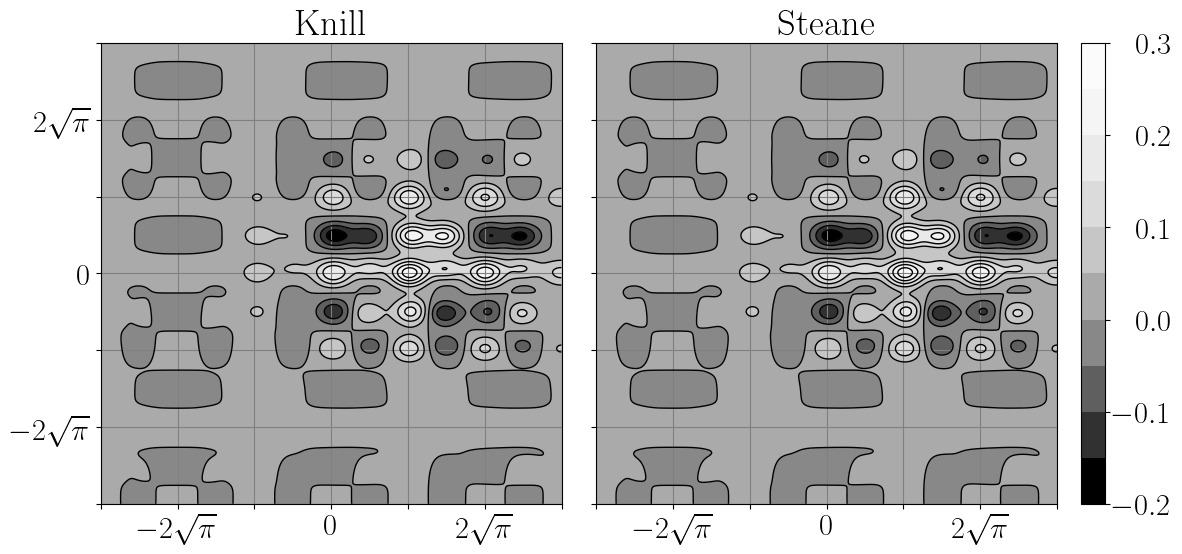

In [13]:
# Plot Wigner function from Knill and Steane

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

# set tick marks to multiples of sqrt(pi)
ticks, labels = get_tickmarks(*window)
labels[0]  = ""
labels[-1] = ""

ax = axs[0]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticks(ticks)
ax.set_yticklabels(labels)

# plotting
num_contours = 10
# colour mapping
from scipy.stats import norm
mu = 0
sigma = 0.65
mapping = lambda x: norm.cdf(x, loc=mu, scale=sigma**2)

# p = 0.5
# mapping = lambda x: np.power(x, p)

colors = mapping(np.linspace(0, 1, num_contours+1))
colors = (colors - colors[0]) / (colors[-1] - colors[0])
color_str = [str(c) for c in colors]

ax = axs[0]
ax.contourf(q, p, z_knill, num_contours, colors=color_str)
ax.contour(q, p, z_knill, num_contours, colors="black", linestyles="solid", linewidths=1)
ax.set_aspect('equal', adjustable='box')
ax.title.set_text('Knill')
ax.grid(color="0.5")

ax = axs[1]
cs = ax.contourf(q, p, z_steane, num_contours, colors=color_str)
ax.contour(q, p, z_steane, num_contours, colors="black", linestyles="solid", linewidths=1)
ax.set_aspect('equal', adjustable='box')
ax.title.set_text('Steane')
ax.grid(color="0.5")

# tight layout
fig.tight_layout()

# make room for new axis
fig.subplots_adjust(right=0.9)
# make axis that is same height as plots
ax = axs[1]
cax = fig.add_axes([
    ax.get_position().x1 + 0.02,
    ax.get_position().y0,
    0.02,
    ax.get_position().height,
])
cbar = fig.colorbar(cs, cax=cax)
# align tick labels to the right so that labels align vertically regardles of their sign
plt.setp(cbar.ax.get_yticklabels(), ha="right")
cbar.ax.tick_params(pad=45)

# plt.savefig("wigner_functions.pdf", format="pdf")
plt.show()

Maximal error: 6.577652776618148e-08


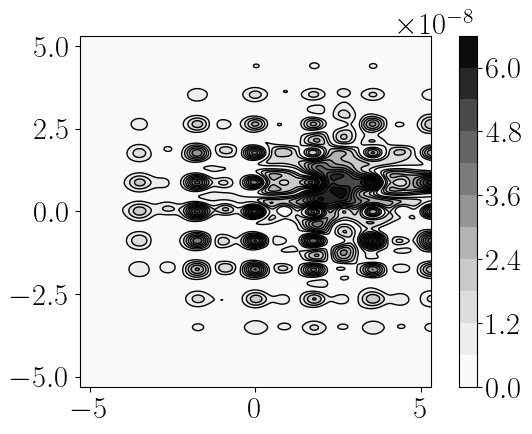

In [7]:
# Plot difference of Wigner function

difference = np.abs(z_knill - z_steane)

fig = plt.figure()
ax = plt.subplot()
cs = ax.contourf(q, p, difference, num_contours, cmap="Grays")
ax.contour(q, p, difference, num_contours, colors="black", linestyles="solid", linewidths=1)
ax.set_aspect('equal', adjustable='box')
plt.colorbar(cs)
plt.tight_layout()

print("Maximal error:", np.max(difference))
plt.show()

In [8]:
# Helper functions for simulation
from mpmath import jtheta
from scipy.signal import fftconvolve
from scipy.interpolate import interp1d as interp

def theta_fun(z, tau):  # Jacobi theta function (of the third kind)
    # The definition in mpmath differ with that of wiki by z -> pi*z
    z = np.pi * z
    q = np.exp(1j*np.pi*tau)
    return float(jtheta(3, z, q))
theta_fun = np.vectorize(theta_fun)  # Make `theta` work for ndarrays. This is unfortunately a slow implementation

def modified_theta(a, b, z, tau):
    return np.exp(np.pi*1j*tau*a**2 + 2j*np.pi*a*(z+b)) * theta_fun(z + a*tau + b, tau)

# For physical GKP states, we use (approximation 3) from T. Matsuura et al. “Equivalence of approximate Gottesman-Kitaev-Preskill codes”. 
# In: Physical Review A 102.3 (Sept. 15, 2020), p. 032408. doi: 10.1103/PhysRevA.102.032408. arXiv: 1910.08301[quant-ph].
gkp = lambda q, kappa, delta, state=[1, 0]: np.exp(-q**2/2 / ((1+delta**2*kappa**2)/kappa**2)) * sum(c * modified_theta(0, mu/2, -q/(2*np.sqrt(np.pi)*(1 + kappa**2*delta**2)), 0.5j*delta**2/(1 + kappa**2*delta**2)) for mu, c in enumerate(state))
gkp_sym = lambda q, epsilon, state=[1, 0]: np.exp(-np.tanh(epsilon)*q**2/2) * sum(c * modified_theta(0, mu/2, -q/(2*np.sqrt(np.pi)*np.cosh(epsilon)), 1j*np.tanh(epsilon)/2) for mu, c in enumerate(state))
comb = lambda q, kappa, delta, alpha: np.exp(-q**2/2 / ((1+delta**2*kappa**2)/kappa**2)) * modified_theta(0, 0, -q/(alpha*(1 + kappa**2*delta**2)), 1j*delta**2/(1 + kappa**2*delta**2))
comb_sym = lambda q, epsilon, alpha: np.exp(-np.tanh(epsilon)*q**2/2) * modified_theta(0, 0, -q/(alpha*np.cosh(epsilon)), 1j*np.tanh(epsilon))

def normalise(qs, state):
    norm = np.sqrt(np.trapz(state * state.conj(), qs))
    return state / norm

def gkp_project(qs, tensor, plus, zero, axis: int=0) -> tuple[np.ndarray, np.ndarray]:
    dq = (qs[-1] - qs[0]) / len(qs)
    tensor = np.moveaxis(tensor, [axis], [0])
    tensor = np.einsum("i...,i -> i...", tensor, plus)
    tensor = fftconvolve(tensor, zero[(...,) + (np.newaxis,)*(len(tensor.shape)-1)], axes=[0], mode="same")
    tensor *= dq  # Since we use discrete convolution to estimate a continuous one we need to include "dq" to get integration

    tensor = np.moveaxis(tensor, [0], [axis])
    return tensor

def logical_density_matrix_element(qs: np.ndarray, state: np.ndarray, logical_index: list[int]) -> complex:
    if len(logical_index) != 2 * state.ndim:
        raise ValueError("Logical index must contain both a left and a right logical index for each axis of the state")
    if not set(logical_index).issubset([0, 1]):
        raise ValueError("Logical indices must be one of 0 or 1")

    SQPI = np.sqrt(np.pi)
    divisions = sum(qs <= qs[0] + SQPI)
    dk = 1/divisions
    ks = np.linspace(-0.5, 0.5, divisions)
    n_span = [math.floor(qs[0]/(2 * SQPI)), math.ceil(qs[-1]/(2 * SQPI))]
    ns = np.array(range(n_span[0], n_span[1]+1))

    q0s = SQPI * (2*ns[np.newaxis, :] + 0 + ks[:, np.newaxis]).flatten()
    q1s = SQPI * (2*ns[np.newaxis, :] + 1 + ks[:, np.newaxis]).flatten()
    qs_list = [q0s, q1s]
    
    left_indices = logical_index[:len(logical_index)//2]
    ket = state
    for axis, index in enumerate(left_indices):
        ket = interp(qs, ket, axis=axis, kind='linear', fill_value=0, assume_sorted=True, bounds_error=False)(qs_list[index])
    
    right_indices = logical_index[len(logical_index)//2:]
    bra = state.conj()
    for axis, index in enumerate(right_indices):
        bra = interp(qs, bra, axis=axis, kind='linear', fill_value=0, assume_sorted=True, bounds_error=False)(qs_list[index])
    
    result = np.tensordot(ket, bra, [list(range(state.ndim))]*2)
    result *= (SQPI * dk)**state.ndim
    return result

def full_logical_density(qs: np.ndarray, state: list[np.ndarray]) -> np.ndarray:
    dim = state.ndim
    N = 2**dim
    result = np.empty((2,2,)*dim, dtype=complex)
    # Is optimised to use the fact that the density matrix is hermitian
    for n in range(N):
        i = format(n, f'0{dim}b')
        i = tuple(int(bit) for bit in i)
        for m in range(n, N):
            j = format(m, f'0{dim}b')
            j = tuple(int(bit) for bit in j)
            matrix_element = logical_density_matrix_element(qs, state, i+j)
            result[i+j] = matrix_element
            result[j+i] = matrix_element.conjugate()
    return result

def logical_fidelity(qs, state):
    rho = full_logical_density(qs, state)
    rho = np.reshape(rho, (2**state.ndim,)*2)
    rho /= np.trace(rho)
    return np.trace(rho@rho).real

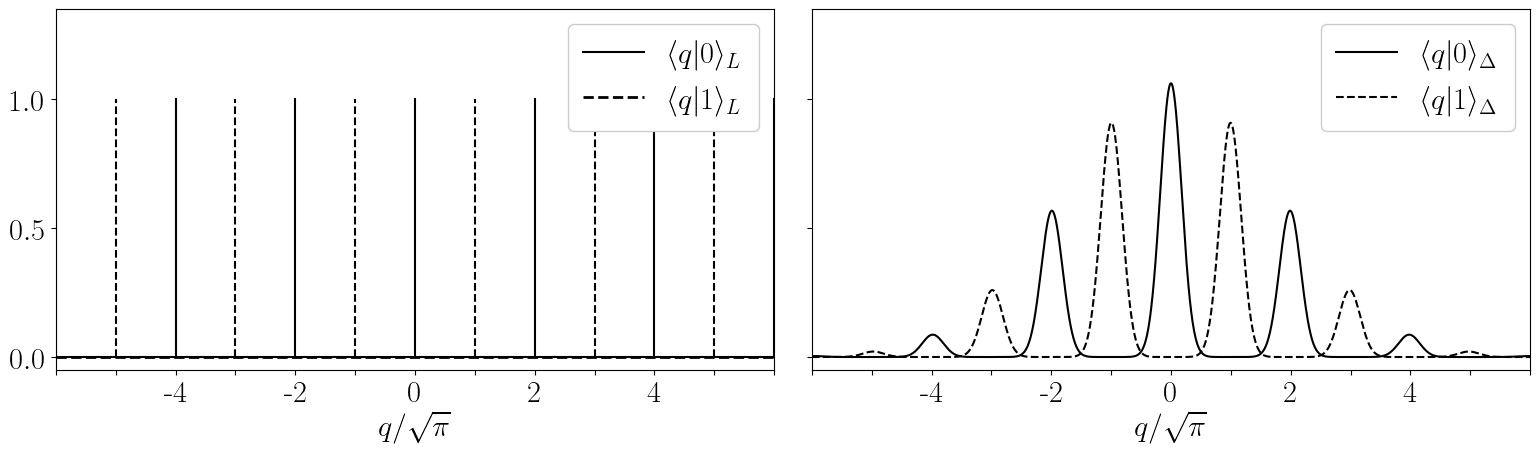

In [9]:
# Plot ideal and approximate GKP basis states

span = np.array([-6, 6]) * np.sqrt(np.pi)
qs = np.linspace(*span, 1500)
ticks, ticklabels = get_tickmarks(*span, True)

zero = gkp_sym(qs, 0.1, [1, 0]).real
one  = gkp_sym(qs, 0.1, [0, 1]).real
zero = normalise(qs, zero)
one = normalise(qs, one)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 5))
axs[1].plot(qs, zero, "k-", label = r"$\langle q | 0 \rangle_\Delta$")
axs[1].plot(qs, one, "k--", label = r"$\langle q | 1 \rangle_\Delta$")

axs[0].plot(span, [0, 0], "k-" , label = r"$\langle q | 0 \rangle_L$")
axs[0].plot(span, [0, 0], "k--", label = r"$\langle q | 1 \rangle_L$", linewidth=2)
for i, x in enumerate(ticks):
    if i % 2 == 0:
        axs[0].plot([x, x], [0, 1], "k-")
    else:
        axs[0].plot([x, x], [0, 1], "k--")

ticklabels[0]  = ""
ticklabels[-1] = ""

axs[0].set_xticks(ticks)
axs[0].set_xticklabels(ticklabels)
axs[0].set_xlim(*span)
axs[0].set_ylim(-0.05, 1.35)

axs[0].legend(loc="upper right", framealpha=1, borderpad=0.5)
axs[1].legend(loc="upper right", framealpha=1, borderpad=0.5)

axs[0].set_xlabel(r"$q / \sqrt{\pi}$")
axs[1].set_xlabel(r"$q / \sqrt{\pi}$")
# axs[0].set_ylabel(r"$\psi(q) = \langle q | \psi \rangle$")

plt.tight_layout()
# plt.savefig("gkp_states.pdf", format="pdf")
plt.show()

Logical fidelity: 0.9273698089903732


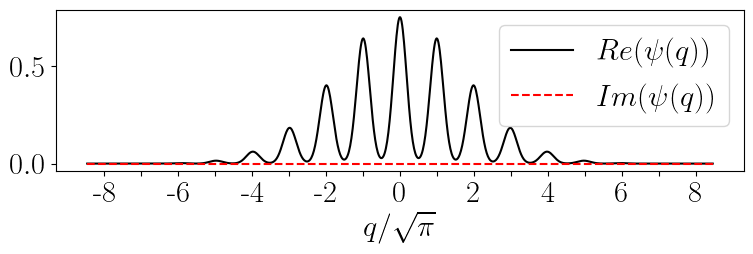

Logical fidelity: 0.8648692996826868


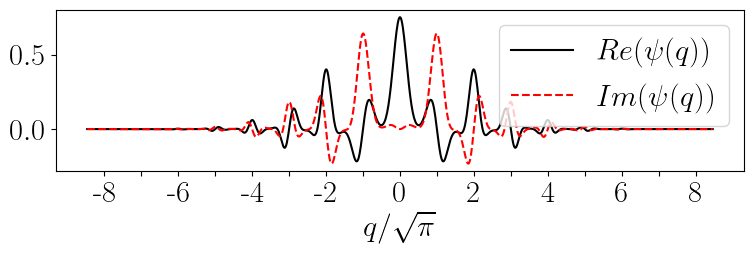

Logical fidelity: 0.944489632012848


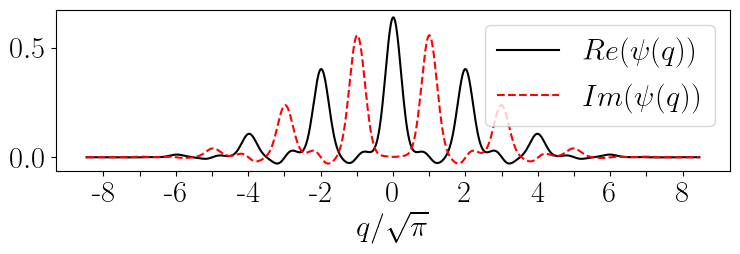

In [10]:
# Single-mode example of imperfect gate (P gate)

epsilon = 0.1
qs = np.linspace(-15, 15, 1000)
dq = (qs[-1] - qs[0]) / len(qs)

plus = normalise(qs, gkp_sym(qs, epsilon, [1, 1]))
zero = normalise(qs, gkp_sym(qs, epsilon, [1, 0]))
init = plus

# Initial state
state = init
print("Logical fidelity:", logical_fidelity(qs, state))
plot_single_mode(qs, state)
plt.show()

# Apply P-gate
state = state * np.exp(0.5j * qs**2)
print("Logical fidelity:", logical_fidelity(qs, state))
plot_single_mode(qs, state)
plt.show()

# Apply GKP projector
state = gkp_project(qs, state, plus, zero)
state = normalise(qs, state)
print("Logical fidelity:", logical_fidelity(qs, state))
plot_single_mode(qs, state)
plt.show()

Logical fidelity: 0.9271919496944907


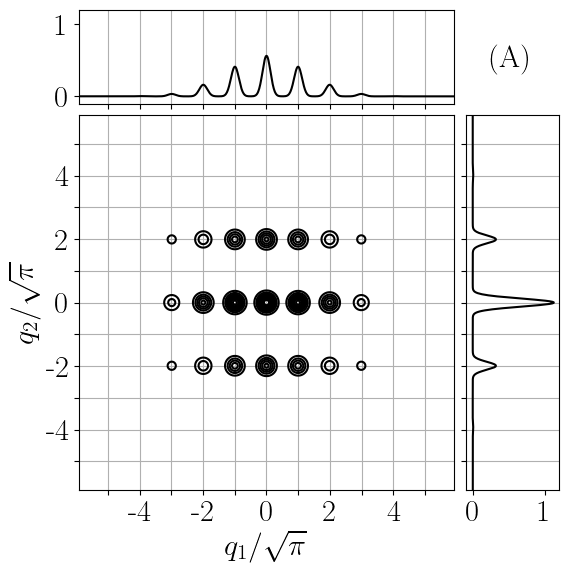

Logical fidelity: 0.6192298536626542


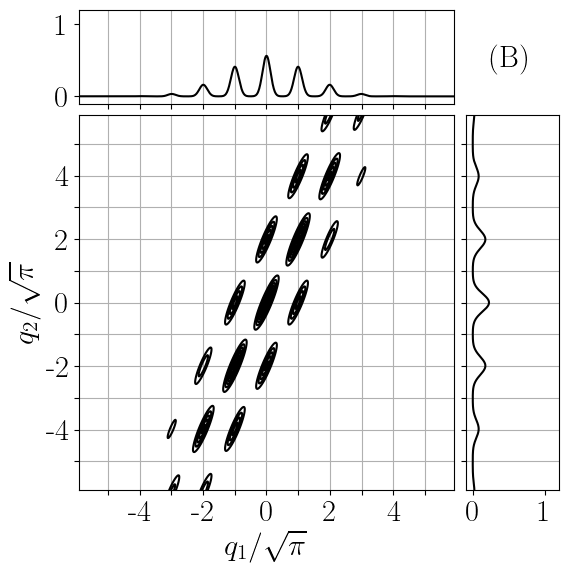

Logical fidelity: 0.9261730033658966


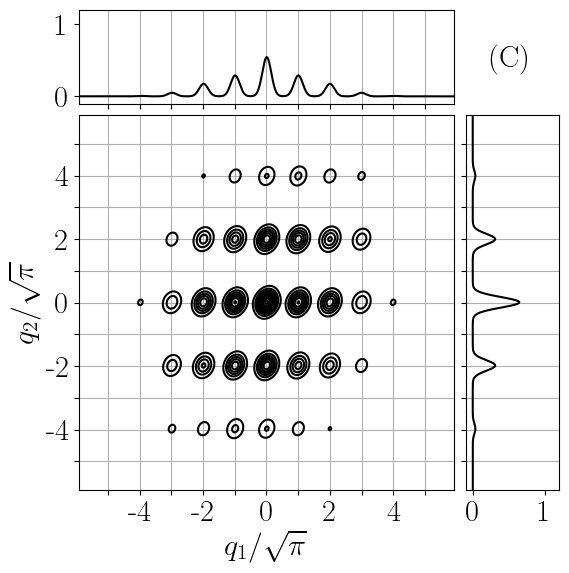

In [11]:
# Two-mode example of imperfect gate (CX gate)

from scipy.interpolate import RegularGridInterpolator

epsilon = 0.1
qs = np.linspace(-15, 15, 1000)
dq = (qs[-1] - qs[0]) / len(qs)

plus = normalise(qs, gkp_sym(qs, epsilon, [1, 1]))
zero = normalise(qs, gkp_sym(qs, epsilon, [1, 0]))

def fix_axes(axs):
    # Fix axis limits
    window = np.array([-1, 1]) * 5.9*np.sqrt(np.pi)
    proj_lim = [-0.1, 1.2]
    axs[0].set_xlim(*window)
    axs[0].set_ylim(*window)
    axs[1].set_ylim(*proj_lim)
    axs[2].set_xlim(*proj_lim)


init = np.einsum("i,j -> ij", plus, zero)

state = init
print("Logical fidelity:", logical_fidelity(qs, state))
_, axs = plot_two_mode(qs, qs, state.real, True)
fix_axes(axs)
axs[1].text(12.5, 0.4, r'(A)', fontsize=22)
# plt.savefig("exampl01.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Apply two controlled displacements: CX^2
x, y = np.meshgrid(qs, qs, indexing="ij")
xp, yp = x, y-2*x
fun = RegularGridInterpolator((qs, qs), state, method='linear', bounds_error=False, fill_value=0)
state = fun((xp, yp))

print("Logical fidelity:", logical_fidelity(qs, state))
temp = state.copy()  # used to prettify plot only
temp[np.abs(state) < 1e-6] = 1e-6
_, axs = plot_two_mode(qs, qs, np.abs(temp), True)
fix_axes(axs)
axs[1].text(12.5, 0.4, r'(B)', fontsize=22)
# plt.savefig("exampl02.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Apply GKP projector to both modes
state = gkp_project(qs, state, plus, zero, 0)
state = gkp_project(qs, state, plus, zero, 1)
norm = np.sqrt(np.einsum("ij,ij", state, state.conj()) * dq**2)
state /= norm

print("Logical fidelity:", logical_fidelity(qs, state))
_, axs = plot_two_mode(qs, qs, np.abs(state), True)
fix_axes(axs)
axs[1].text(12.5, 0.4, r'(C)', fontsize=22)
# plt.savefig("exampl03.pdf", format="pdf", bbox_inches='tight')
plt.show()

Logical fidelity: 0.28454675034832594


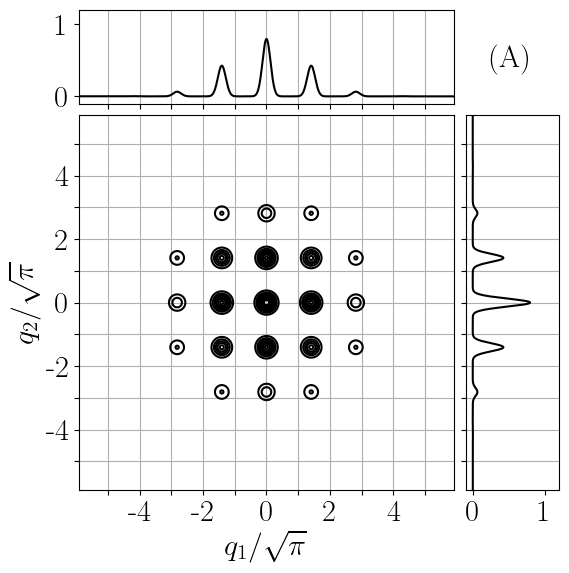

Logical fidelity: 0.8649509094514638


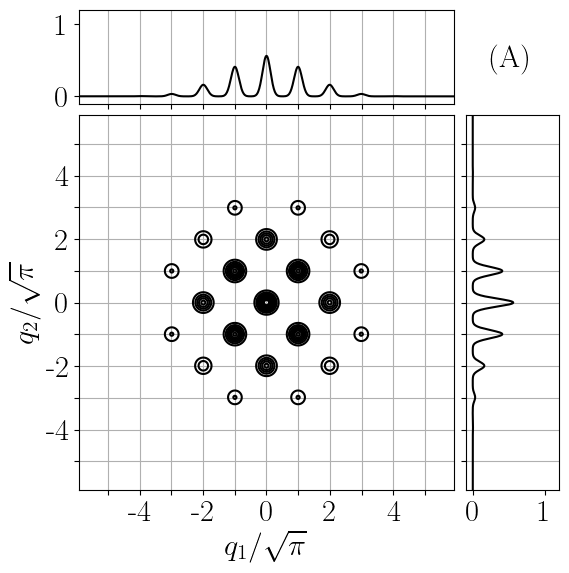

Logical fidelity: 0.9271919496944907


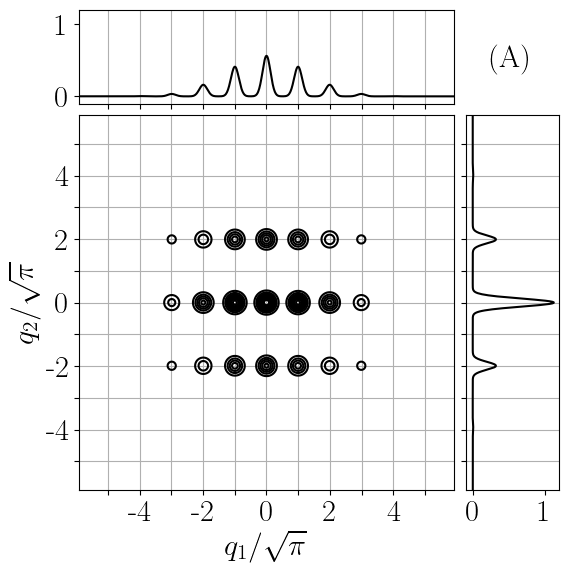

Logical fidelity: 0.9161354226348406


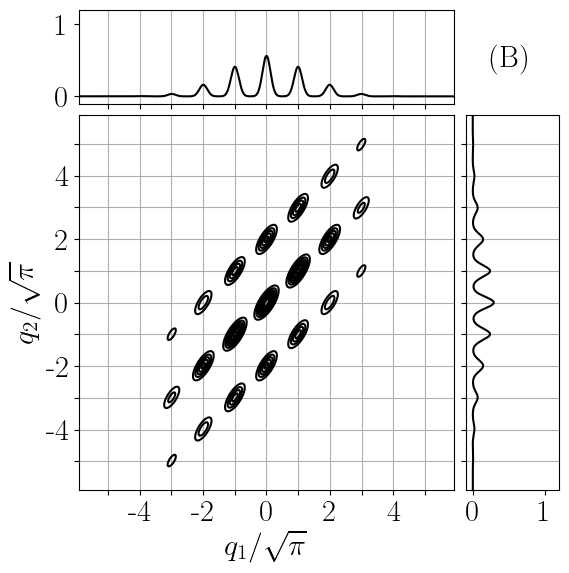

In [12]:
# Knill vs. qunaught error correction

from scipy.interpolate import RegularGridInterpolator

epsilon = 0.1
qs = np.linspace(-15, 15, 1000)
dq = (qs[-1] - qs[0]) / len(qs)

plus = normalise(qs, gkp_sym(qs, epsilon, [1, 1]))
zero = normalise(qs, gkp_sym(qs, epsilon, [1, 0]))
qunaught = normalise(qs, comb_sym(qs, epsilon, np.sqrt(2*np.pi)))

def fix_axes(axs):
    # Fix axis limits
    window = np.array([-1, 1]) * 5.9*np.sqrt(np.pi)
    proj_lim = [-0.1, 1.2]
    axs[0].set_xlim(*window)
    axs[0].set_ylim(*window)
    axs[1].set_ylim(*proj_lim)
    axs[2].set_xlim(*proj_lim)



# Bell state from qunaught states
# qunaught = normalise(qs, gkp_sym(qs*np.sqrt(2), epsilon, [1, 0]))
state = np.einsum("i,j -> ij", qunaught, qunaught)

print("Logical fidelity:", logical_fidelity(qs, state))
_, axs = plot_two_mode(qs, qs, state.real, True)
fix_axes(axs)
axs[1].text(12.5, 0.4, r'(A)', fontsize=22)
# plt.savefig("exampl01.pdf", format="pdf", bbox_inches='tight')
plt.show()

# from quadrature_basis import fourier
# state = fourier(qs, state, 0)

# # Apply controlled displacement: CX
# x, y = np.meshgrid(qs, qs, indexing="ij")
# xp, yp = x+y, y
# fun = RegularGridInterpolator((qs, qs), state, method='linear', bounds_error=False, fill_value=0)
# state = fun((xp, yp))

# Apply beam splitter (rotate in 2-D position space)
theta = np.pi/4
x, y = np.meshgrid(qs, qs)
xp, yp = np.cos(-theta) * x - np.sin(-theta) * y, np.sin(-theta) * x + np.cos(-theta) * y
fun = RegularGridInterpolator((qs, qs), state, method='linear', bounds_error=False, fill_value=0)
state = fun((xp, yp))

print("Logical fidelity:", logical_fidelity(qs, state))
_, axs = plot_two_mode(qs, qs, state.real, True)
fix_axes(axs)
axs[1].text(12.5, 0.4, r'(A)', fontsize=22)
# plt.savefig("exampl01.pdf", format="pdf", bbox_inches='tight')
plt.show()


# Bell state from GKP states
init = np.einsum("i,j -> ij", plus, zero)

state = init
print("Logical fidelity:", logical_fidelity(qs, state))
_, axs = plot_two_mode(qs, qs, state.real, True)
fix_axes(axs)
axs[1].text(12.5, 0.4, r'(A)', fontsize=22)
# plt.savefig("exampl01.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Apply controlled displacement: CX
x, y = np.meshgrid(qs, qs, indexing="ij")
xp, yp = x, y-x
fun = RegularGridInterpolator((qs, qs), state, method='linear', bounds_error=False, fill_value=0)
state = fun((xp, yp))

print("Logical fidelity:", logical_fidelity(qs, state))
temp = state.copy()  # used to prettify plot only
temp[np.abs(state) < 1e-6] = 1e-6
_, axs = plot_two_mode(qs, qs, np.abs(temp), True)
fix_axes(axs)
axs[1].text(12.5, 0.4, r'(B)', fontsize=22)
# plt.savefig("exampl02.pdf", format="pdf", bbox_inches='tight')
plt.show()

# # Apply GKP projector to both modes
# state = gkp_project(qs, state, plus, zero, 0)
# state = gkp_project(qs, state, plus, zero, 1)
# norm = np.sqrt(np.einsum("ij,ij", state, state.conj()) * dq**2)
# state /= norm

# print("Logical fidelity:", logical_fidelity(qs, state))
# _, axs = plot_two_mode(qs, qs, np.abs(state), True)
# fix_axes(axs)
# axs[1].text(12.5, 0.4, r'(C)', fontsize=22)
# # plt.savefig("exampl03.pdf", format="pdf", bbox_inches='tight')
# plt.show()